# Feature engineering
The purpose of this nootebook is to discover which feature is important for our model.

### Libraries

In [1]:
# external
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


# internal
from dataLoader.DataLoader import DataLoader
from models.RfModel import RFModel
from evaluations.Evaluations import metrics

# Plotting
import matplotlib.pyplot as plt
from utils.plots import Plots

### 1 - Slinding window approach?

We will use the first 20 years of data for training predictive models and the final year for evaluating models.

The data will be divided into weeks, 14 values  (since for each day we've computed 2 values of the tidal coefficient). And the next 14 values would constitute the prediction target for the models.

In [2]:
DL = DataLoader()
DL.createDataFrame()

data successfully loaded 


C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [3]:
RF = RFModel(params = {"n_estimators":100})

In [4]:
X_train_reshaped, X_test_reshaped, y_train, y_test = DL.splitDataSet(past_values=14, step=14)

In [5]:
RF.fit(X_train_reshaped, y_train)

In [6]:
y_predicted = RF.predict(X_test_reshaped)
score, scores = RF.evaluate(X_test_reshaped, y_test)

the RMSE for all predictions is:6.438936179176691
----------------------------------------------------------------------------------------------------


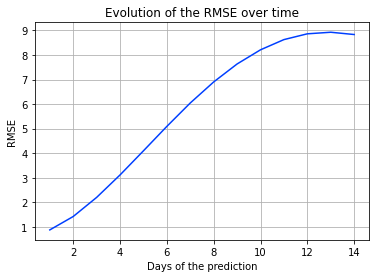

In [7]:
print("the RMSE for all predictions is:{}".format(score))

print("-"*100)

plt.plot(np.arange(14)+1, scores)
plt.xlabel("Days of the prediction")
plt.ylabel("RMSE")
plt.grid()
plt.title("Evolution of the RMSE over time");

- The errors above indicate that our model performs well for the first value of the first day prediction and it does worse as we want to predict further steps in time. But Since the RMSE computed here has the same unit "roughly speaking: our actual value has no unit".

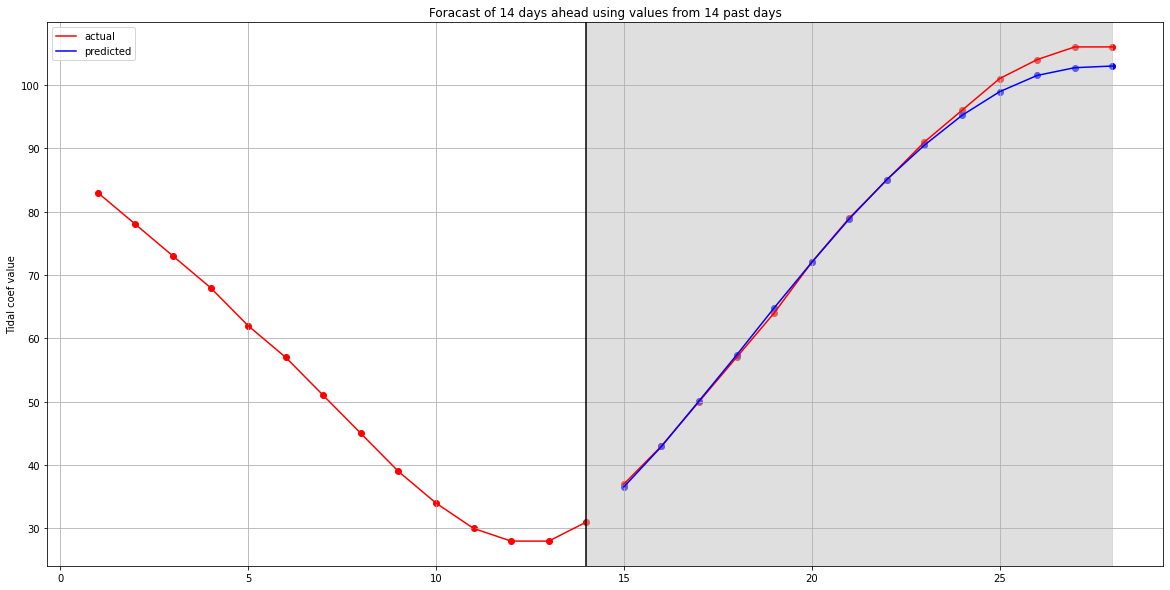

In [8]:
pl = Plots((20,10))
pl.plotForcast(X_test_reshaped, y_test, y_predicted, 88)

### 2 - Time Features only?

In [9]:
DL = DataLoader()
DL.createDataFrame()
DL.addTimRelatedFeatures()

C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


data successfully loaded 
Date-Time features added with sucess!


In [10]:
DL.data.head()

,dateTime,coef,hijri_day,hijri_month,hijri_year,hour
0,2000-01-01 12:21:00,48,24,9,1420,12
1,2000-01-02 00:53:00,50,25,9,1420,0
2,2000-01-02 13:19:00,53,25,9,1420,13
3,2000-01-03 01:45:00,56,26,9,1420,1
4,2000-01-03 14:08:00,60,26,9,1420,14


In [14]:
df = DL.data

In [15]:
df['year'] = df["dateTime"].dt.year.values
df_test = df[df["year"]==2021]
df_train = df[df["year"]!=2021]

In [16]:
df_train.head()

,dateTime,coef,hijri_day,hijri_month,hijri_year,hour,year
0,2000-01-01 12:21:00,48,24,9,1420,12,2000
1,2000-01-02 00:53:00,50,25,9,1420,0,2000
2,2000-01-02 13:19:00,53,25,9,1420,13,2000
3,2000-01-03 01:45:00,56,26,9,1420,1,2000
4,2000-01-03 14:08:00,60,26,9,1420,14,2000


In [17]:
X_train = df_train.iloc[:,2:-1]
y_train = df_train.iloc[:,1]

X_test = df_test.iloc[:,2:-1]
y_test = df_test.iloc[:,1]

In [20]:
RF = RFModel(params = {"n_estimators":100})

In [21]:
RF.fit(X_train, y_train)

In [22]:
y_predicted = RF.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)

In [23]:
print("overal root mean squared error is: {}".format(rmse))

overal root mean squared error is: 10.11390052500949


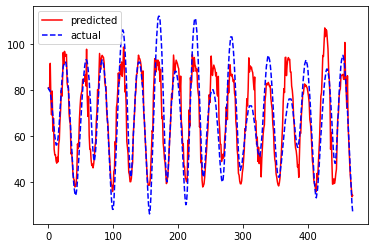

In [24]:
plt.plot(np.arange(y_predicted.shape[0]), y_predicted, '-r', label = "predicted")
plt.plot(np.arange(y_test.shape[0]), y_test, '--b', label = 'actual')
plt.legend();

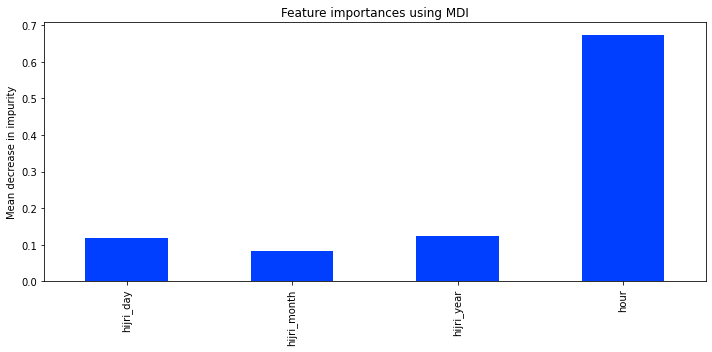

In [25]:
rf_model = RF.model

importances = rf_model.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize = (10, 5))
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### 3- Moon & sun related features only?

In [26]:
DL = DataLoader()
DL.createDataFrame()
DL.addMoonSunFeatures()

C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


data successfully loaded 
Features added successfully!


In [27]:
df = DL.data
df.head()

,dateTime,coef,moon_phase,earth_moon_distance,sun_moon_distance,libration_lat,libration_long,subsolar_latitude,elongation,earth_sun_distance
0,2000-01-01 12:21:00,48,0.272007,0.002680,0.982105,-0.118238,0.096808,0.011175,-1.094243,0.983332
1,2000-01-02 00:53:00,50,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325
2,2000-01-02 13:19:00,53,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325
3,2000-01-03 01:45:00,56,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322
4,2000-01-03 14:08:00,60,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322


In [28]:
df['year'] = df["dateTime"].dt.year.values
df_test = df[df["year"]==2021]
df_train = df[df["year"]!=2021]

In [30]:
X_train = df_train.iloc[:,2:-1]
y_train = df_train.iloc[:,1]

X_test = df_test.iloc[:,2:-1]
y_test = df_test.iloc[:,1]

In [34]:
RF = RFModel(params = {"n_estimators":100})
RF.fit(X_train, y_train)
y_predicted = RF.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)

In [35]:
print("overal root mean squared error is: {}".format(rmse))

overal root mean squared error is: 4.965595874235595


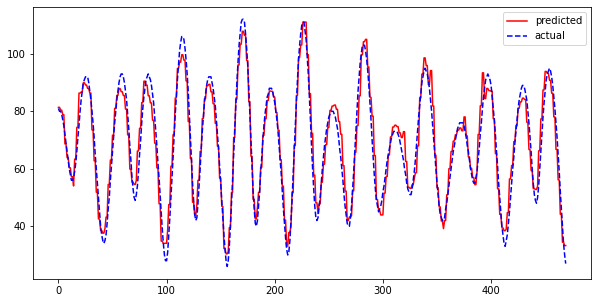

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(y_predicted.shape[0]), y_predicted, '-r', label = "predicted")
plt.plot(np.arange(y_test.shape[0]), y_test, '--b', label = 'actual')
plt.legend();

- Features importances based on mean decrease in impurity

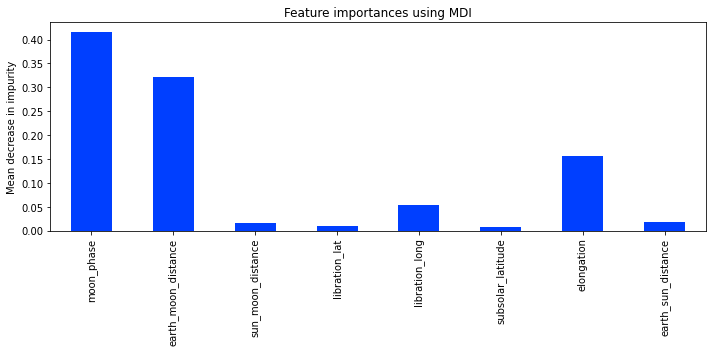

In [37]:
rf_model = RF.model

importances = rf_model.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize = (10, 5))
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### 4 - Both 2 and 3?

In [38]:
DL = DataLoader()
DL.createDataFrame()
DL.addMoonSunFeatures()
DL.addTimRelatedFeatures()

C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


data successfully loaded 
Features added successfully!
Date-Time features added with sucess!


In [39]:
df = DL.data
df.head()

,dateTime,coef,moon_phase,earth_moon_distance,sun_moon_distance,libration_lat,libration_long,subsolar_latitude,elongation,earth_sun_distance,hijri_day,hijri_month,hijri_year,hour
0,2000-01-01 12:21:00,48,0.272007,0.002680,0.982105,-0.118238,0.096808,0.011175,-1.094243,0.983332,24,9,1420,12
1,2000-01-02 00:53:00,50,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325,25,9,1420,0
2,2000-01-02 13:19:00,53,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325,25,9,1420,13
3,2000-01-03 01:45:00,56,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322,26,9,1420,1
4,2000-01-03 14:08:00,60,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322,26,9,1420,14


In [40]:
df['year'] = df["dateTime"].dt.year.values
df_test = df[df["year"]==2021]
df_train = df[df["year"]!=2021]

In [41]:
df_train.head()

,dateTime,coef,moon_phase,earth_moon_distance,sun_moon_distance,libration_lat,libration_long,subsolar_latitude,elongation,earth_sun_distance,hijri_day,hijri_month,hijri_year,hour,year
0,2000-01-01 12:21:00,48,0.272007,0.002680,0.982105,-0.118238,0.096808,0.011175,-1.094243,0.983332,24,9,1420,12,2000
1,2000-01-02 00:53:00,50,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325,25,9,1420,0,2000
2,2000-01-02 13:19:00,53,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325,25,9,1420,13,2000
3,2000-01-03 01:45:00,56,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322,26,9,1420,1,2000
4,2000-01-03 14:08:00,60,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322,26,9,1420,14,2000


In [42]:
X_train = df_train.iloc[:,2:-1]
y_train = df_train.iloc[:,1]

X_test = df_test.iloc[:,2:-1]
y_test = df_test.iloc[:,1]

In [43]:
RF = RFModel(params = {"n_estimators":100})
RF.fit(X_train, y_train)
y_predicted = RF.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)

In [44]:
print("overal root mean squared error is: {}".format(rmse))

overal root mean squared error is: 5.039136113061191


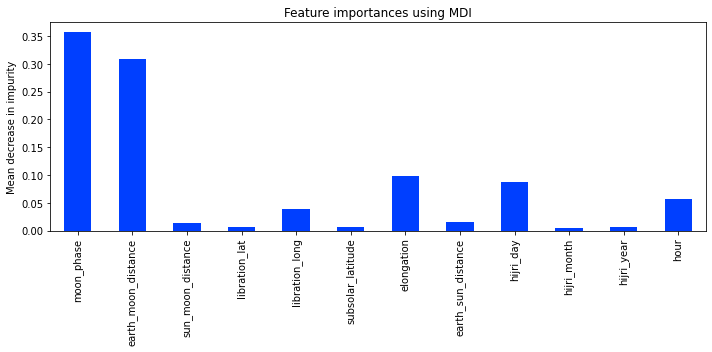

In [45]:
rf_model = RF.model

importances = rf_model.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize = (10, 5))
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()